In [1]:
%config InlineBackend.figure_format = 'svg' # change output plot display format to 'svg'

# import the required modules for this notebook
import numpy
import matplotlib.pyplot as plt

# import the helper functions from the parent directory,
# these help with things like graph plotting and notebook layout
import sys
sys.path.append('..')
from helper_functions import *

# set things like fonts etc - comes from helper_functions
set_notebook_preferences()

# add a show/hide code button - also from helper_functions
toggle_code(title = "setup code")

# The effects of model complexity: overfitting and generalisation in regression

[Previously](regression_non-linear.ipynb) we have fit polynomial functions to regression data using the least squares and maximum likelihood approaches. In this section we will explore one of the problems with these estimation techniques: overfitting.

Returning to our simple 1D regression dataset, let's fit a polynomial model

\begin{align}
y_n = f_{\mathbf{w}}(x_n) + \sigma_y \epsilon_n = \sum_{d=0}^D w_d x^d_n + \sigma_y \epsilon_n \;\; \text{where} \;\; \epsilon \sim \mathcal{N}(0,1) 
\end{align}

and vary the order of the polynomial $D = 1, 2, ... 9$. Below are the resulting maximum likelihood fits of the underlying function $f_{\mathbf{w}}(x)$ shown in black:

<>:25: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:25: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\Dell\AppData\Local\Temp\ipykernel_18092\1588271810.py:25: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if D % 3 is not 1:


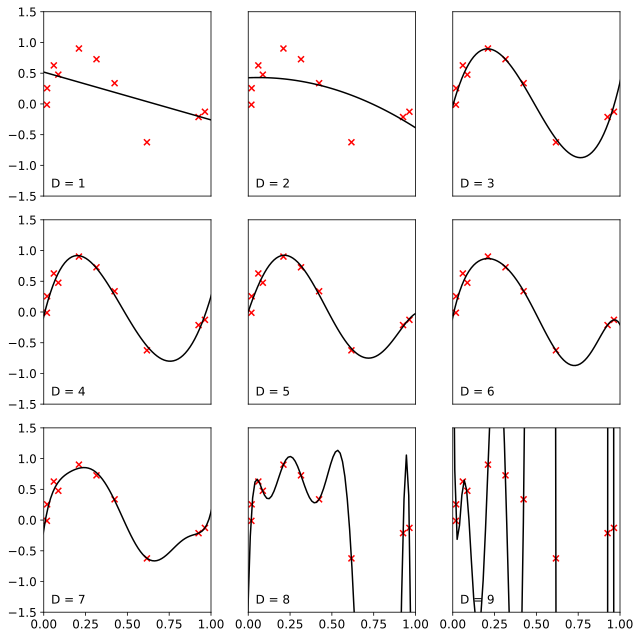

In [2]:
x_nonlin = np.load('reg_nonlin_x.npy') # load inputs from a prepared non-linear dataset
y_nonlin = np.load('reg_nonlin_y.npy') # load corresponding outputs
xs = np.linspace(-0.2, 1.2, 100) # 100 points equispaced between 0 and 1


fig = plt.figure(figsize = (9, 9)) # figure on which to plot the subfigures - you don't have to worry about this

for D in range(1, 10):

    phi = np.array([[x_ ** d for d in range(D + 1)] for x_ in x_nonlin]) # training design matrix, as before
    
    w = np.linalg.inv((phi.T).dot(phi)).dot(phi.T).dot(y_nonlin) # Moore-Penrose pseudoinverse
    
    phi_pred = np.array([[x_ ** d for d in range(D + 1)] for x_ in xs]) # design matrix of evaluation points as before
    
    ys = phi_pred.dot(w) # model predictions as before
    
    plt.subplot(3, 3, D)
    plt.scatter(x_nonlin, y_nonlin, marker = 'x', color = 'red') # plot 
    plt.plot(xs, ys, color = 'black')
    plt.text(0.25, -1.4, s = 'D = ' + str(D), color = 'black', fontsize = 12,
                 horizontalalignment = 'right', verticalalignment = 'bottom')
    plt.xlim([0, 1])
    plt.ylim([-1.5, 1.5])
    if D % 3 is not 1:
        remove_axes('y')
    if D < 7:
        remove_axes('x')
plt.tight_layout()
plt.show()

toggle_code()

The plots show that, for low order polynomials, there is structure in the data which is not captured by the regression function. This is called **underfitting**. As the order of the polynomial increases, the model becomes more flexible and the fitted curve $f(x)$ can pass closer to each datapoint thereby reducing the cost function. Intermediate settings of $D$ lead to well fit models. The most complex model (\\(D = 9\\)) has \\(10\\) degrees of freedom (including the constant \\(w_0\\)), which is equal to the number of datapoints. This provides the model with enough degrees of freedom for the polynomial to pass exactly through every data point achieving a cost of 0. 

Although the $D=9$ solution has minimised our training cost, intuitively it looks poor. Do we really expect such an extreme polynomial to accurately predict unseen test data? This phenomenon is called **overfitting** and it is a serious problem that can occur when the model complexity becomes large compared to the amount of training data. Maximum likelihood fitting is particularly succeptible to this phenomenon. Overfitted models exhibit very small training errors but are too well adapted for the training data and *learn the noise* of that data too. Consequently, they make poor predictions about unseen datapoints \\(-\\) they fail to generalise. 

### Diagnosing under-fitting and over-fitting: training and validation sets

How can we automatically evaluate model performance and diagnose overfitting? One useful approach is to use only a subset of the data to train the model (the training set) leaving out a portion of the data to assess the fit (the **validation set**). The model's performance on the train and validation sets can be compared to diagnose overfitting: if predictions made on the training set are accurate, but those made on the test set are poor, it is likely that there is overfitting. Note that setting aside some data for validation does mean that there are fewer data to train on, potentially reducing the quality of the predictions. There are a wide range of refinements to this basic <a href="https://en.wikipedia.org/wiki/Cross-validation_(statistics)">**cross validation**</a> approach.

Let's use a validation set comprising 40 unseen data points to assess the quality of the models fit above.

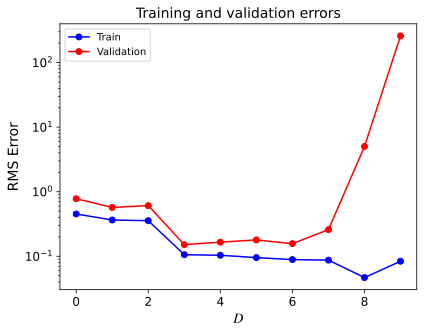

In [4]:
x_ext = np.load('reg_nonlin_x_extended.npy')
y_ext = np.load('reg_nonlin_y_extended.npy')
x_train, x_test, y_train, y_test = x_ext[:10], x_ext[10:], y_ext[:10], y_ext[10:]
D_max = 9;
train_err, test_err = [], [] # lists to store training and test error as D varies
for D in range(D_max+1):
    
    phi = np.array([[x_ ** d for d in range(D + 1)] for x_ in x_train]) # design matrix for training points
    
    w = np.linalg.solve( (phi.T).dot(phi) , (phi.T).dot(y_train) )
    
    y_trained = phi.dot(w) # evaluate polynomial at training points
    
    train_err.append(((y_trained - y_train) ** 2).mean() ** 0.5) # store train errors
    
    phi_pred = np.array([[x_ ** d for d in range(D + 1)] for x_ in x_test]) # design matrix for test points
    
    y_pred = phi_pred.dot(w) # evaluate polynomial at test data points
    
    test_err.append(((y_pred - y_test)**2).mean()**0.5) # store test errors

ax = matplotlib.pyplot.subplot(1,1,1)
plt.plot(np.arange(0, D_max+1), train_err, color = 'blue', marker = 'o', label = 'Train')
plt.plot(np.arange(0, D_max+1), test_err, color = 'red', marker = 'o', label = 'Validation')
plt.gca().legend()
ax.set_yscale("log")

beautify_plot({"title":"Training and validation errors", "x":"$D$", "y": 'RMS Error'}) # add a legend for maximum style
plt.show()

toggle_code()

As the order of the polynomial increases, the training error steadily decreases due to the model's increased flexibility, whereas the validation error initially decreases and then increases again. For low $D$ there is a small difference between train and validation errors indicating a small amount of overfitting. By $D=8$ the model has started to significantly overfit the training data and no longer makes sensible predictions on the validation set. 

## Summary

**Overfitting** occurs when a training procedure causes a model to capture aspects of the training data that are irrelevant or deleterious for predicting unseen test data.

Overfitting can be monitored by comparing the quality of predictions on the **training set** and a held-out **validation set**. A validation error that is much larger than the test error reveals overfitting.  

Having learned how to diagnose and quantify overfitting, in the next section we investigate how to use [regularisation](regression_regularisation.ipynb) to mitigate its effects.
## Questions

1. Make a plot of the training and validation errors for a Gaussian basis function model. Instead of changing the number of basis functions, choose D=10 and alter the width of the basis function. Comment on the role of the width in the context of the complexity of the model.

<details>
<summary>Answer</summary>
<div>
The width of the Gaussian basis function controls the typical length-scale over which the regression function changes. It therefore controls the flexibility of the model and with it the model's susceptibility to overfitting. Notice that for short length-scales, more basis functions may be required to obtain a sensible fit. 
</div>
</details>

2. An experimenter uses a single validation set to evaluate i) many different choices of basis function $\phi_d(x)$, ii) many different orders of model $D$, and iii) many different hyper parameter settings e.g. $\sigma_{\mathbf{w}}$. They choose to use the model with the smallest validation error to make predictions on a test set. They are surprised that the resulting predictions are poor - after all they used a validation set to guard against overfitting. What has happened? How could they have improved their approach?

<details>
<summary>Answer</summary>
<div>
The experimenter has overfit the _validation set_. If the validation set is used to decide amongst a very large set of models, it is perfectly possible to overfit at this second level model fitting. 
    
Approaches that might help in this case are i) <a href="https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation">k-fold cross validation</a> (which effective increases the size of the validation set), and ii) [ensembling](https://en.wikipedia.org/wiki/Ensemble_learning) (averaging) model predictions rather than taking the best one. Another option would be to build a large model that contains the individual model as special cases and use Bayesian inference for fitting.
</div>
</details>